In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch
from aurora import Aurora, Batch, Metadata, rollout
from cdsapi import Client

In [3]:
cities = {
    "Los Angeles": (34.05, -118.24),
    "Chicago": (41.88, -87.63),
    "Austin": (30.27, -97.74),
    "New York City": (40.71, -74.01),
    "Miami": (25.76, -80.19),
    "Philadelphia": (39.95, -75.17),
    "Denver": (39.74, -104.99),
}

def to_360(lon):
    return lon if lon >= 0 else 360 + lon


In [6]:
def download_era5_day(y, m, d, save_dir):
    c = Client()
    date_str = f"{y:04d}-{m:02d}-{d:02d}"
    times = ["00:00", "06:00", "12:00", "18:00"]

    save_dir.mkdir(exist_ok=True)

    # Surface-level
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure"],
            "year": f"{y:04d}",
            "month": f"{m:02d}",
            "day": f"{d:02d}",
            "time": times,
            "format": "netcdf",
        },
        str(save_dir / f"{date_str}-surface-level.nc")
    )

    # Atmospheric-level
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": ["temperature", "u_component_of_wind", "v_component_of_wind", "specific_humidity", "geopotential"],
            "pressure_level": ["50", "100", "150", "200", "250", "300", "400", "500", "600", "700", "850", "925", "1000"],
            "year": f"{y:04d}",
            "month": f"{m:02d}",
            "day": f"{d:02d}",
            "time": times,
            "format": "netcdf",
        },
        str(save_dir / f"{date_str}-atmospheric.nc")
    )

In [14]:
def predict_daily_max(date, model, static_ds, base_path, lat, lon, steps=6, return_all=False):
    date_str = date.strftime("%Y-%m-%d")
    surf_ds = xr.open_dataset(base_path / f"{date_str}-surface-level.nc")
    atmos_ds = xr.open_dataset(base_path / f"{date_str}-atmospheric.nc")

    def crop(ds):
        if ds.longitude.max() > 180:
            ds = ds.assign_coords(longitude=(ds.longitude % 360))
        return ds.sel(latitude=slice(lat+2, lat-2), longitude=slice(to_360(lon)-2, to_360(lon)+2))

    surf_tile = crop(surf_ds)
    atmos_tile = crop(atmos_ds)
    static_tile = crop(static_ds)

    batch = Batch(
        surf_vars={
            "2t": torch.from_numpy(surf_tile["t2m"].values[:2][None]),
            "10u": torch.from_numpy(surf_tile["u10"].values[:2][None]),
            "10v": torch.from_numpy(surf_tile["v10"].values[:2][None]),
            "msl": torch.from_numpy(surf_tile["msl"].values[:2][None]),
        },
        static_vars={
            "z": torch.from_numpy(static_tile["z"].values[0]),
            "slt": torch.from_numpy(static_tile["slt"].values[0]),
            "lsm": torch.from_numpy(static_tile["lsm"].values[0]),
        },
        atmos_vars={
            "t": torch.from_numpy(atmos_tile["t"].values[:2][None]),
            "u": torch.from_numpy(atmos_tile["u"].values[:2][None]),
            "v": torch.from_numpy(atmos_tile["v"].values[:2][None]),
            "q": torch.from_numpy(atmos_tile["q"].values[:2][None]),
            "z": torch.from_numpy(atmos_tile["z"].values[:2][None]),
        },
        metadata=Metadata(
            lat=torch.from_numpy(surf_tile.latitude.values),
            lon=torch.from_numpy(surf_tile.longitude.values),
            time=(surf_tile.valid_time.values.astype("datetime64[s]").tolist()[1],),
            atmos_levels=tuple(int(l) for l in atmos_tile.pressure_level.values),
        )
    )

    preds = list(rollout(model, batch, steps=steps))

    lat_vals = preds[0].metadata.lat.numpy()
    lon_vals = preds[0].metadata.lon.numpy()
    i = np.abs(lat_vals - lat).argmin()
    j = np.abs(lon_vals - to_360(lon)).argmin()

    temps_K = [pred.surf_vars["2t"][0, 0, i, j].item() for pred in preds]
    times = [pred.metadata.time[0] for pred in preds]
    temps_C = [t - 273.15 for t in temps_K]

    max_idx = np.argmax(temps_C)
    max_temp_C = temps_C[max_idx]
    time_of_max_temp = times[max_idx]

    result = {
        "max_temp_C": max_temp_C,
        "time_of_max_temp": np.datetime64(time_of_max_temp).astype(datetime)
    }

    if return_all:
        result["all_predictions"] = list(zip(times, temps_C))

    return result

In [8]:
def get_era5_max(date, base_path, lat, lon):
    ds = xr.open_dataset(base_path / f"{date.strftime('%Y-%m-%d')}-surface-level.nc")
    if ds.longitude.max() > 180:
        ds = ds.assign_coords(longitude=(ds.longitude % 360))

    lat_idx = np.abs(ds.latitude.values - lat).argmin()
    lon_idx = np.abs(ds.longitude.values - to_360(lon)).argmin()
    max_temp_C = ds["t2m"].values[:, lat_idx, lon_idx].max() - 273.15
    return float(max_temp_C)

In [11]:
start_date = datetime(2025, 6, 15)
end_date = datetime(2025, 6, 30)
base_path = Path("~/downloads/era5").expanduser()

for n in range((end_date - start_date).days):
    date = start_date + timedelta(days=n)
    try:
        print(f"Downloading ERA5 for {date.date()}...")
        download_era5_day(date.year, date.month, date.day, base_path)
    except Exception as e:
        print(f"⚠️ Failed to download {date.date()}: {e}")

2025-07-08 11:48:28,667 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 11:48:29,649 INFO Request ID is 226d6a1b-115a-44ff-b515-6c8bfab73064
2025-07-08 11:48:29,886 INFO status has been updated to accepted
2025-07-08 11:48:39,109 INFO status has been updated to running
2025-07-08 11:48:52,211 INFO status has been updated to successful


a75c137a3266450999493a2eafd8c1e4.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 11:48:58,831 INFO Request ID is 15d57cb8-3871-414b-a1ad-afe8285197ea
2025-07-08 11:48:59,039 INFO status has been updated to accepted
2025-07-08 11:49:08,209 INFO status has been updated to running
2025-07-08 11:50:55,134 INFO status has been updated to successful


34dc231561aee188e1785061ea4519c5.nc:   0%|          | 0.00/424M [00:00<?, ?B/s]

2025-07-08 11:56:30,386 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 11:56:31,151 INFO Request ID is e1753288-79a9-45c9-82c0-92d4c4078de8
2025-07-08 11:56:31,374 INFO status has been updated to accepted
2025-07-08 11:56:46,192 INFO status has been updated to running
2025-07-08 11:56:54,008 INFO status has been updated to successful


c89d2c67befe2aa8c82a806c4404a35d.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 11:57:00,552 INFO Request ID is 026081b8-adea-4555-a266-fa621512a469
2025-07-08 11:57:00,809 INFO status has been updated to accepted
2025-07-08 11:57:10,019 INFO status has been updated to running
2025-07-08 11:57:23,116 INFO status has been updated to accepted
2025-07-08 11:57:34,729 INFO status has been updated to running
2025-07-08 11:59:54,920 INFO status has been updated to successful


a61bdc997e1f0bd1dd63055743050d78.nc:   0%|          | 0.00/417M [00:00<?, ?B/s]

2025-07-08 12:03:38,835 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:03:39,946 INFO Request ID is 56ca3ed7-ccd7-4447-9b73-493ab4a75751
2025-07-08 12:03:40,221 INFO status has been updated to accepted
2025-07-08 12:03:49,399 INFO status has been updated to running
2025-07-08 12:04:02,959 INFO status has been updated to successful


45a388c604362c3b0e8b542ca0a425eb.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 12:06:31,672 INFO Request ID is ac317240-160d-469b-916a-45dbe0126444
2025-07-08 12:06:31,888 INFO status has been updated to accepted
2025-07-08 12:06:40,946 INFO status has been updated to running
2025-07-08 12:09:26,252 INFO status has been updated to successful


15cd4664e99bababd15419ad31bacdf4.nc:   0%|          | 0.00/413M [00:00<?, ?B/s]

2025-07-08 12:12:42,645 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:12:43,593 INFO Request ID is 715b806f-99f0-4889-ab9c-5086563c402f
2025-07-08 12:12:43,840 INFO status has been updated to accepted
2025-07-08 12:12:53,424 INFO status has been updated to running
2025-07-08 12:13:06,515 INFO status has been updated to successful


60fe568bd55cc7259b74069109480fdc.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 12:13:19,841 INFO Request ID is b9e89478-a8dc-416e-817c-377cc13ef371
2025-07-08 12:13:20,071 INFO status has been updated to accepted
2025-07-08 12:13:34,445 INFO status has been updated to running
2025-07-08 12:15:15,891 INFO status has been updated to successful


f2fc019e11d5dccf9624407604fc0d3d.nc:   0%|          | 0.00/416M [00:00<?, ?B/s]

2025-07-08 12:19:27,626 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:19:28,626 INFO Request ID is 6235c62c-b085-4f2a-b38f-0da001e3a41a
2025-07-08 12:19:28,914 INFO status has been updated to accepted
2025-07-08 12:20:02,884 INFO status has been updated to successful


be078673023333f73242d99ccfacbe46.nc:   0%|          | 0.00/26.1M [00:00<?, ?B/s]

2025-07-08 12:20:08,867 INFO Request ID is cce871f5-c8a8-44f8-b14f-07f968db8812
2025-07-08 12:20:09,075 INFO status has been updated to accepted
2025-07-08 12:20:18,113 INFO status has been updated to running
2025-07-08 12:20:42,894 INFO status has been updated to accepted
2025-07-08 12:21:00,212 INFO status has been updated to running
2025-07-08 12:22:04,894 INFO status has been updated to successful


23ba83bac431b7fd2e90d99ab49f4d3c.nc:   0%|          | 0.00/422M [00:00<?, ?B/s]

2025-07-08 12:25:55,495 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:25:56,320 INFO Request ID is 7bbabc68-4fbb-4eab-bfde-326dd3ca8881
2025-07-08 12:25:56,559 INFO status has been updated to accepted
2025-07-08 12:26:06,151 INFO status has been updated to running
2025-07-08 12:26:11,420 INFO status has been updated to accepted
2025-07-08 12:26:30,827 INFO status has been updated to successful


3c57d03489b58d14509e33b2967c0fc1.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 12:26:38,940 INFO Request ID is afc3666e-7a51-4400-b297-92df9822bf07
2025-07-08 12:26:39,145 INFO status has been updated to accepted
2025-07-08 12:27:01,240 INFO status has been updated to running
2025-07-08 12:28:35,246 INFO status has been updated to successful


9a7c683807565ded67db0f4884fcc14.nc:   0%|          | 0.00/417M [00:00<?, ?B/s]

2025-07-08 12:34:59,502 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:35:00,347 INFO Request ID is d4eaa4f9-6bac-4b40-a2a0-bf1ce596bfec
2025-07-08 12:35:00,569 INFO status has been updated to accepted
2025-07-08 12:35:10,639 INFO status has been updated to running
2025-07-08 12:35:23,829 INFO status has been updated to successful


8c62b8c51b51150aad78f452a96cbab9.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 12:35:35,566 INFO Request ID is faf7ee2b-bfd0-4337-b495-8bf34f01b367
2025-07-08 12:35:36,118 INFO status has been updated to accepted
2025-07-08 12:35:45,234 INFO status has been updated to running
2025-07-08 12:37:32,140 INFO status has been updated to successful


e364f4eea88dc5b691f6730c73fbcfb6.nc:   0%|          | 0.00/413M [00:00<?, ?B/s]

2025-07-08 12:41:39,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:41:40,268 INFO Request ID is 866764eb-a8ef-4bb6-a93c-bf8902849de6
2025-07-08 12:41:40,566 INFO status has been updated to accepted
2025-07-08 12:41:49,886 INFO status has been updated to running
2025-07-08 12:42:02,969 INFO status has been updated to successful


8b966215637efddccebb5480f8947c9.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 12:42:24,082 INFO Request ID is bcf424c7-7288-4d6d-8c26-a6e38b1626ef
2025-07-08 12:42:24,281 INFO status has been updated to accepted
2025-07-08 12:42:38,691 INFO status has been updated to running
2025-07-08 12:44:25,480 INFO status has been updated to successful


545040b98fa77b64ad6e98d89526b73e.nc:   0%|          | 0.00/416M [00:00<?, ?B/s]

2025-07-08 12:48:05,334 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 12:48:06,370 INFO Request ID is b18797a9-ed3e-4718-9255-6bae639fc07e
2025-07-08 12:48:06,603 INFO status has been updated to accepted
2025-07-08 12:48:15,778 INFO status has been updated to running
2025-07-08 12:48:28,982 INFO status has been updated to successful


ea1e70455bdc9371e0bd30868a55442c.nc:   0%|          | 0.00/26.4M [00:00<?, ?B/s]

2025-07-08 12:48:44,262 INFO Request ID is 22fe9225-4709-4a90-aeac-057dd2b3e144
2025-07-08 12:48:44,492 INFO status has been updated to accepted
2025-07-08 12:48:59,086 INFO status has been updated to running
2025-07-08 12:50:40,406 INFO status has been updated to successful


fdbc999ccd589dedd2d9c00c6d510a58.nc:   0%|          | 0.00/419M [00:00<?, ?B/s]

Recovering from connection error [HTTPSConnectionPool(host='object-store.os-api.cci2.ecmwf.int', port=443): Read timed out.], attempt 1 of 500
Retrying in 120 seconds


fdbc999ccd589dedd2d9c00c6d510a58.nc:  93%|#########2| 389M/419M [00:00<?, ?B/s]

2025-07-08 13:03:56,112 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 13:03:57,173 INFO Request ID is a4645fd3-261c-44bc-a294-180632e1c0c7
2025-07-08 13:03:57,391 INFO status has been updated to accepted
2025-07-08 13:04:12,128 INFO status has been updated to running
2025-07-08 13:04:19,922 INFO status has been updated to successful


5890c3b34bc7ef4211d3a2c00e0c7f35.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 13:04:26,700 INFO Request ID is 86183213-e641-4791-abef-02231a3450ce
2025-07-08 13:04:26,915 INFO status has been updated to accepted
2025-07-08 13:04:36,029 INFO status has been updated to running
2025-07-08 13:07:21,328 INFO status has been updated to successful


b673a7d07595717c965425ede0c80f66.nc:   0%|          | 0.00/421M [00:00<?, ?B/s]

2025-07-08 13:11:10,145 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 13:11:11,177 INFO Request ID is 0d24b0fe-d4ed-4d64-bb39-4ac6fb19f235
2025-07-08 13:11:11,486 INFO status has been updated to accepted
2025-07-08 13:11:26,466 INFO status has been updated to successful


7254900bf060db2392fc05465e7a1f66.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 13:11:38,869 INFO Request ID is ba928c18-fd2d-48b8-b943-538b11d53c34
2025-07-08 13:11:39,078 INFO status has been updated to accepted
2025-07-08 13:11:48,204 INFO status has been updated to running
2025-07-08 13:13:34,955 INFO status has been updated to successful


2f68b4fb75c93a14a37fc18e6385b381.nc:   0%|          | 0.00/416M [00:00<?, ?B/s]

2025-07-08 13:19:09,364 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 13:19:10,216 INFO Request ID is 0b7f10c3-cf90-4499-94f0-0300267737a5
2025-07-08 13:19:10,523 INFO status has been updated to accepted
2025-07-08 13:19:44,416 INFO status has been updated to successful


14d184a607eb71dc3a64d3c1d08f0c88.nc:   0%|          | 0.00/25.9M [00:00<?, ?B/s]

2025-07-08 13:19:51,203 INFO Request ID is 7f8d9a5a-35e4-43fa-b3b3-6a62a0df20d8
2025-07-08 13:19:51,578 INFO status has been updated to accepted
2025-07-08 13:20:01,161 INFO status has been updated to running
2025-07-08 13:20:14,448 INFO status has been updated to accepted
2025-07-08 13:20:43,438 INFO status has been updated to running
2025-07-08 13:21:48,004 INFO status has been updated to successful


a7d6a9ccc9c3b1407db371be0a1fd001.nc:   0%|          | 0.00/421M [00:00<?, ?B/s]

2025-07-08 13:26:17,651 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 13:26:18,559 INFO Request ID is 3bdc0797-c029-46e6-b83e-8dc890bde796
2025-07-08 13:26:18,771 INFO status has been updated to accepted
2025-07-08 13:26:28,035 INFO status has been updated to running
2025-07-08 13:26:41,127 INFO status has been updated to successful


c97c3a57e7d98597999a52caab936819.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 13:26:48,734 INFO Request ID is 51ed1a1c-846a-42c2-875d-f7c180b3ab23
2025-07-08 13:26:48,934 INFO status has been updated to accepted
2025-07-08 13:26:54,373 INFO status has been updated to running
2025-07-08 13:26:57,950 INFO status has been updated to successful


4fff97c5f4c5b02be2c7d028b7fc10d8.nc:   0%|          | 0.00/415M [00:00<?, ?B/s]

2025-07-08 13:30:56,774 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 13:30:57,809 INFO Request ID is c9b6b3a0-40e5-4433-bf1d-455c7bba9c07
2025-07-08 13:30:58,151 INFO status has been updated to accepted
2025-07-08 13:31:20,259 INFO status has been updated to successful


33799661fb8ec12c1245831766f819b4.nc:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

2025-07-08 13:31:30,293 INFO Request ID is 3f8c33be-f62a-47b8-b50f-78e51ec32826
2025-07-08 13:31:30,500 INFO status has been updated to accepted
2025-07-08 13:31:39,646 INFO status has been updated to successful


c0ade76faf92bd646be592ac75ccbd24.nc:   0%|          | 0.00/424M [00:00<?, ?B/s]

2025-07-08 13:35:05,389 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-08 13:35:06,505 INFO Request ID is f78b3cbd-46f7-462e-9100-dec256510061
2025-07-08 13:35:06,718 INFO status has been updated to accepted
2025-07-08 13:35:15,938 INFO status has been updated to running
2025-07-08 13:35:21,221 INFO status has been updated to successful


1d2e902da6be75f088abab17bc1f600b.nc:   0%|          | 0.00/26.2M [00:00<?, ?B/s]

2025-07-08 13:35:35,629 INFO Request ID is 6fa9bb32-8056-41f4-ba33-d32492f35f43
2025-07-08 13:35:35,827 INFO status has been updated to accepted
2025-07-08 13:35:44,907 INFO status has been updated to running
2025-07-08 13:35:50,179 INFO status has been updated to successful


3ed64dfac370c483e48177d420237343.nc:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [15]:
start_date = datetime(2025, 6, 15)
end_date = datetime(2025, 6, 30)
base_path = Path("~/downloads/era5").expanduser()

static_ds = xr.open_dataset(base_path / "static.nc")
model = Aurora(use_lora=False)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")
model = model.to("cpu")

all_data = []
all_predictions = []

for city, (lat, lon) in cities.items():
    for n in range((end_date - start_date).days):
        date = start_date + timedelta(days=n)
        try:
            pred = predict_daily_max(date, model, static_ds, base_path, lat, lon, return_all=True)
            actual = get_era5_max(date, base_path, lat, lon)
            all_data.append({
                "city": city,
                "date": date.date(),
                "forecast": pred["max_temp_C"],
                "truth": actual,
                "time_of_max": pred["time_of_max_temp"]
            })

            # Store detailed prediction points for potential later plotting
            for time, temp in pred["all_predictions"]:
                all_predictions.append({
                    "city": city,
                    "date": date.date(),
                    "timestamp": time,
                    "temp": temp
                })

        except FileNotFoundError:
            continue

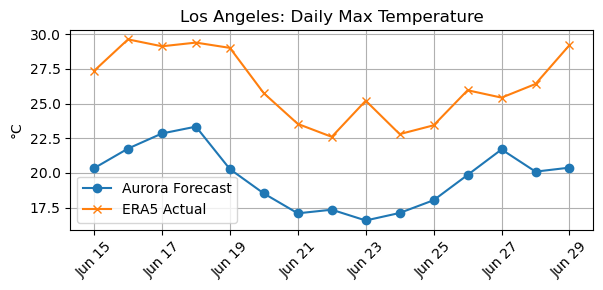

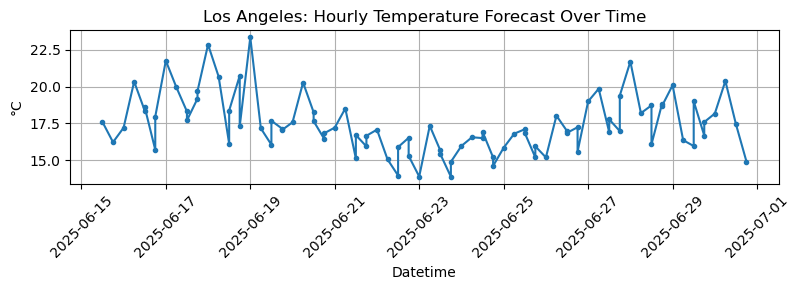

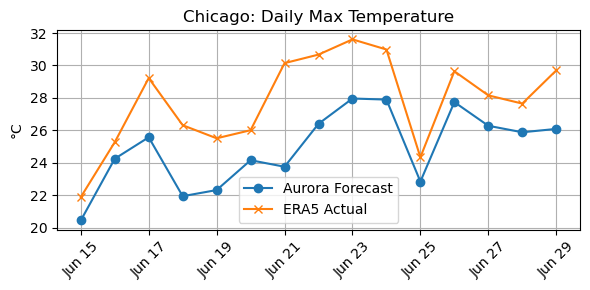

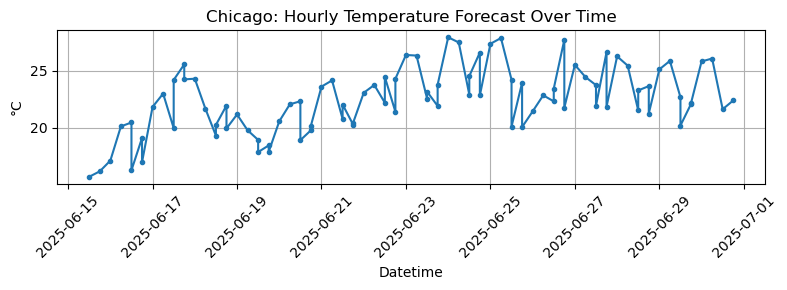

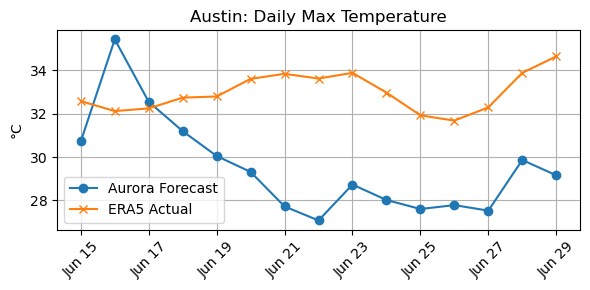

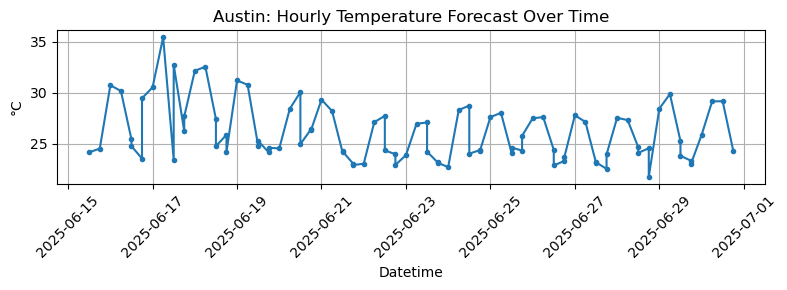

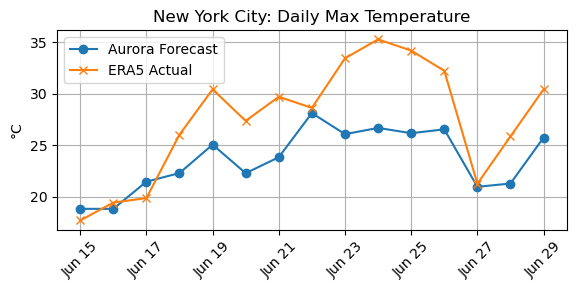

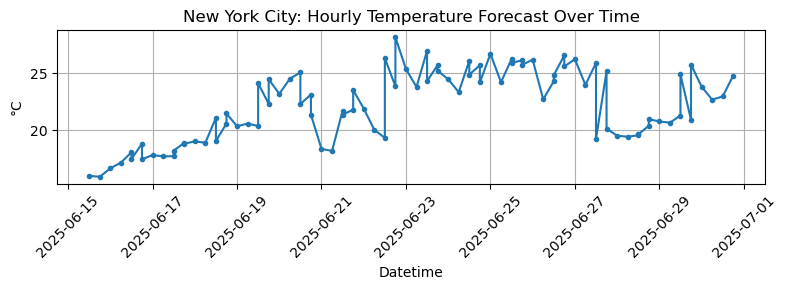

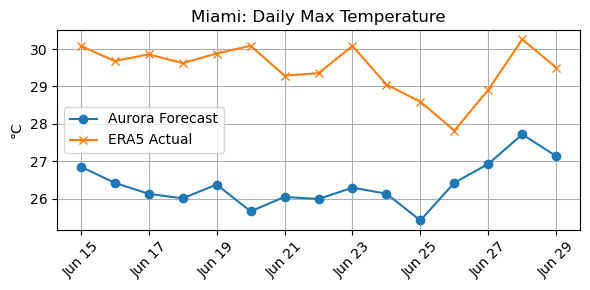

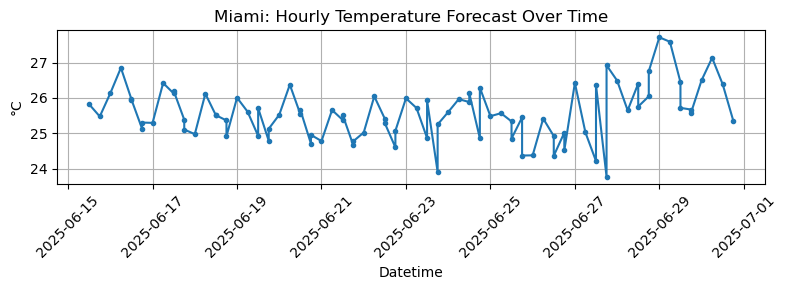

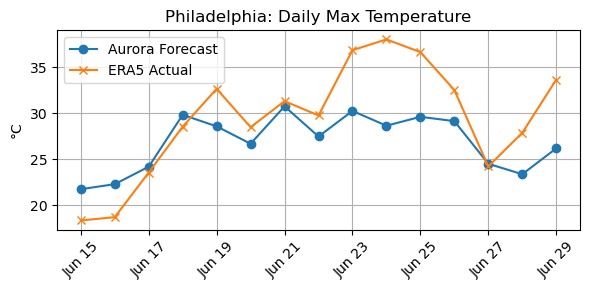

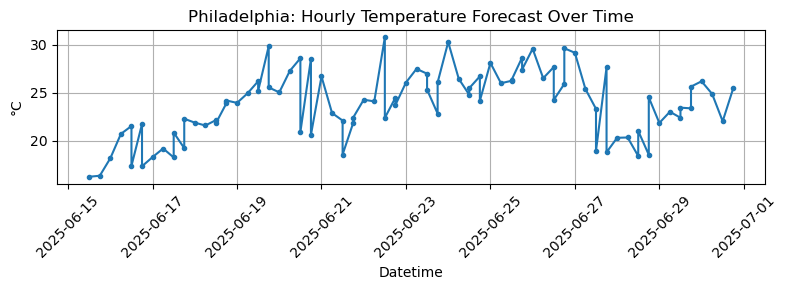

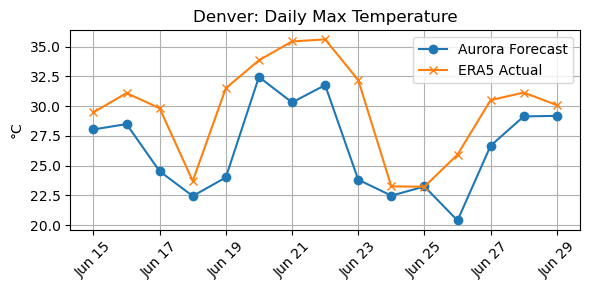

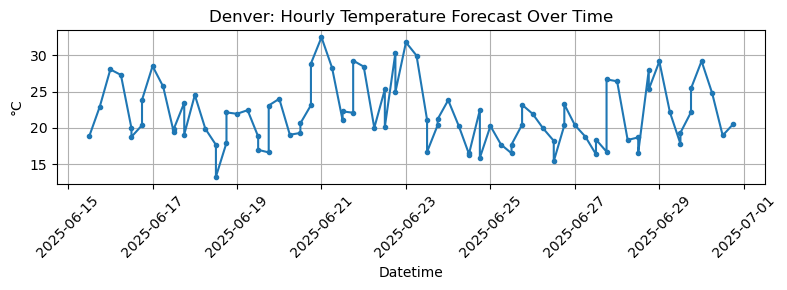

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure datetime format
df_daily["date"] = pd.to_datetime(df_daily["date"])
df_all_preds["timestamp"] = pd.to_datetime(df_all_preds["timestamp"])

# Loop through each city
for city in df_daily["city"].unique():
    df_city_daily = df_daily[df_daily["city"] == city].copy()
    df_city_daily = df_city_daily.dropna(subset=["forecast", "truth"])
    df_city_daily = df_city_daily.sort_values("date")

    df_city_hourly = df_all_preds[df_all_preds["city"] == city].copy()
    df_city_hourly = df_city_hourly.sort_values("timestamp")

    # === Plot 1: Daily Max Temp Forecast vs Actual ===
    plt.figure(figsize=(6, 3))
    plt.plot(df_city_daily["date"], df_city_daily["forecast"], marker="o", label="Aurora Forecast")
    plt.plot(df_city_daily["date"], df_city_daily["truth"], marker="x", label="ERA5 Actual")
    plt.title(f"{city}: Daily Max Temperature")
    plt.ylabel("°C")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    plt.tight_layout()
    plt.show()

    # === Plot 2: Hourly Forecast Over Time ===
    plt.figure(figsize=(8, 3))
    plt.plot(df_city_hourly["timestamp"], df_city_hourly["temp"], marker=".", linestyle="-")
    plt.title(f"{city}: Hourly Temperature Forecast Over Time")
    plt.ylabel("°C")
    plt.xlabel("Datetime")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
city_name = "Los Angeles"
df_city_preds = df_all_preds[df_all_preds["city"] == city_name].copy()
df_city_preds = df_city_preds.sort_values("timestamp")

print(df_city_preds)

           city        date           timestamp       temp
0   Los Angeles  2025-06-15 2025-06-15 12:00:00  17.597681
1   Los Angeles  2025-06-15 2025-06-15 18:00:00  16.230249
2   Los Angeles  2025-06-15 2025-06-16 00:00:00  17.209161
3   Los Angeles  2025-06-15 2025-06-16 06:00:00  20.334894
4   Los Angeles  2025-06-15 2025-06-16 12:00:00  18.368555
..          ...         ...                 ...        ...
85  Los Angeles  2025-06-29 2025-06-29 18:00:00  17.593835
86  Los Angeles  2025-06-29 2025-06-30 00:00:00  18.170679
87  Los Angeles  2025-06-29 2025-06-30 06:00:00  20.376184
88  Los Angeles  2025-06-29 2025-06-30 12:00:00  17.451837
89  Los Angeles  2025-06-29 2025-06-30 18:00:00  14.912225

[90 rows x 4 columns]


In [21]:
# View daily max forecast and actual (ERA5) temperatures
city_name = "Denver"
df_city_max = df_daily[df_daily["city"] == city_name].copy()

print(df_city_max[["date", "forecast", "truth", "time_of_max"]])


          date   forecast      truth         time_of_max
90  2025-06-15  28.036676  29.477197 2025-06-16 00:00:00
91  2025-06-16  28.487543  31.094385 2025-06-17 00:00:00
92  2025-06-17  24.520441  29.817896 2025-06-18 00:00:00
93  2025-06-18  22.438470  23.699182 2025-06-19 06:00:00
94  2025-06-19  24.003351  31.505334 2025-06-20 00:00:00
95  2025-06-20  32.448389  33.845728 2025-06-21 00:00:00
96  2025-06-21  30.307214  35.434869 2025-06-22 18:00:00
97  2025-06-22  31.763116  35.606104 2025-06-23 00:00:00
98  2025-06-23  23.811456  32.189905 2025-06-24 00:00:00
99  2025-06-24  22.471948  23.248193 2025-06-24 18:00:00
100 2025-06-25  23.241846  23.223108 2025-06-26 18:00:00
101 2025-06-26  20.385370  25.925317 2025-06-27 00:00:00
102 2025-06-27  26.668817  30.500818 2025-06-27 18:00:00
103 2025-06-28  29.131311  31.137079 2025-06-29 00:00:00
104 2025-06-29  29.179712  30.081934 2025-06-30 00:00:00


In [24]:
from sklearn.metrics import root_mean_squared_error

# Per-city RMSE
for city in df_daily["city"].unique():
    df_city = df_daily[df_daily["city"] == city].dropna(subset=["forecast", "truth"])
    rmse = root_mean_squared_error(df_city["truth"], df_city["forecast"])
    print(f"{city} RMSE: {rmse:.2f} °C")

# Overall RMSE
df_valid = df_daily.dropna(subset=["forecast", "truth"])
overall_rmse = root_mean_squared_error(df_valid["truth"], df_valid["forecast"])
print(f"\nOverall RMSE across all cities: {overall_rmse:.2f} °C")

Los Angeles RMSE: 6.79 °C
Chicago RMSE: 3.23 °C
Austin RMSE: 4.29 °C
New York City RMSE: 4.99 °C
Miami RMSE: 3.19 °C
Philadelphia RMSE: 4.63 °C
Denver RMSE: 4.15 °C

Overall RMSE across all cities: 4.61 °C
